In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#TODO
# add a different loss function
# change NoiseGenerator
# change noise addition to embeddings instead of images
# check inference with static noise

In [ ]:
%cd '/content/drive/MyDrive/IDL Image Generation'

/content/drive/MyDrive/IDL Image Generation


In [ ]:
!pip install transformers torch --quiet

In [ ]:
import os
import ast
import csv

import numpy as np
import pandas as pd

from PIL import Image

import torch
from transformers import CLIPProcessor, CLIPModel

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score


In [ ]:
DIFFUSION_MODELS = ["openjourney", "titan", "dalle", "real"]
ROOT = '/content/drive/MyDrive/IDL Image Generation'

In [ ]:
def collect_images(generators):
  generated_images = {}
  for directory in generators:
    for filepath in os.listdir(os.path.join(ROOT, "data", directory)):
      if filepath.lower().endswith(".jpg"):
        full_path = os.path.join(ROOT, "data", directory, filepath)
        id_idx = filepath.rfind('_') + 1
        id = filepath[id_idx:-4]
        label = 1 if directory == "real" else 0
        generated_images[full_path] = {
            "generator": directory,
            "label": label, # 0 = fake, 1 = real
            "id": id,
        }
  return generated_images


In [ ]:
images = collect_images(DIFFUSION_MODELS)

In [ ]:
for generator in ["openjourney_v4"]:
  if generator == "real":
    continue

  test_df = df[df['Generator'] == generator]
  train_df = df[df['Generator'] != generator]

  # Reset the index for both partitions
  test_df = test_df.reset_index(drop=True)
  train_df = train_df.reset_index(drop=True)

  X_test = np.stack(test_df["Features"].apply(string_to_np).to_numpy())
  y_test = test_df["Label"].to_numpy()

  X_train = np.stack(train_df["Features"].apply(string_to_np).to_numpy())
  y_train = train_df["Label"].to_numpy()

  print(f"Results for no-{generator} model")
  svm = train(X_train, y_train)
  print(f"Results on {generator}:")
  metrics = evaluate(svm, X_test, y_test)
  print("******************************************")



Results for no-openjourney_v4 model
Training accuracy: 0.9979
Results on openjourney_v4:
Accuracy: 0.9968
Precision: 1.0000
Recall: 0.9968
F1 Score: 0.9984
AUC: nan
mAP: 1.0000
******************************************


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
class ArtEmbeddingDataset(Dataset):
    """
    A dataset class for loading art image embeddings and labels from a CSV file.

    Expected CSV columns:
      - "Filepath": location of the original image.
      - "Features": string representation of the image embedding vector.
      - "Label": the label indicating whether the image is real or AI–generated.
    """
    def __init__(self, csv_file, transform=None, ai_only=False):
        self.data = pd.read_csv(csv_file, usecols=["Filepath", "Features", "Label"])
        self.transform = transform

        # Filter for AI-generated only if requested (Label=0)
        if ai_only:
            self.data = self.data[self.data["Label"] == 0]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filepath = row["Filepath"]
        features = string_to_np(row["Features"])
        label = row["Label"]

        sample = {"filepath": filepath, "features": features, "label": label}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [ ]:
class AITestDataset(Dataset):
        def __init__(self, X, y):
            self.features = X
            self.labels = y

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return {
                "features": self.features[idx],
                "label": self.labels[idx]
            }

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NoiseGenerator(nn.Module):
    def __init__(self, embedding_dim=768):
        super(NoiseGenerator, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, embedding_dim)
        self.relu = nn.ReLU()
        # Optionally, you can add an activation (e.g., tanh) to constrain the noise.

    def forward(self, x):
        # x is expected to have shape (B, embedding_dim)
        noise = self.relu(self.fc1(x))
        noise = self.relu(self.fc2(noise))
        noise = self.fc3(noise)
        perturbed_embedding = x + noise  # add learned noise to the input embedding
        return perturbed_embedding, noise


Running on: cpu


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualization saved to /content/drive/MyDrive/IDL Image Generation/original_embeddings_tsne.png


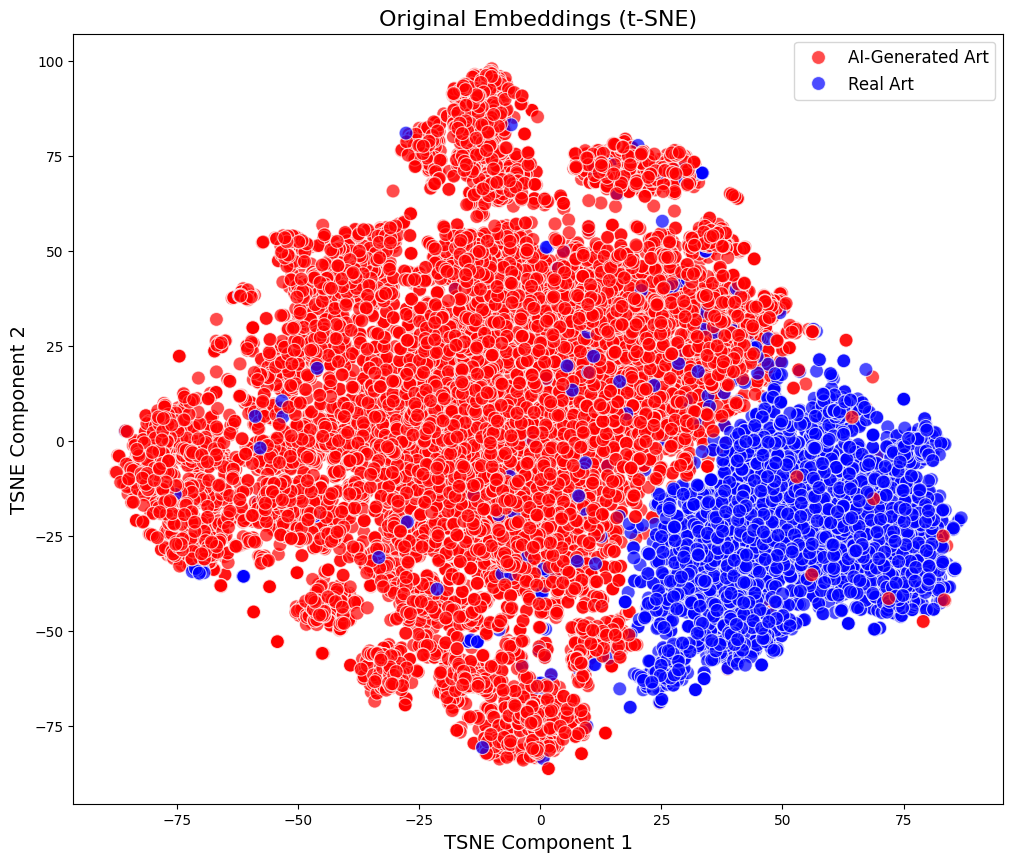

Visualization saved to /content/drive/MyDrive/IDL Image Generation/original_embeddings_pca.png


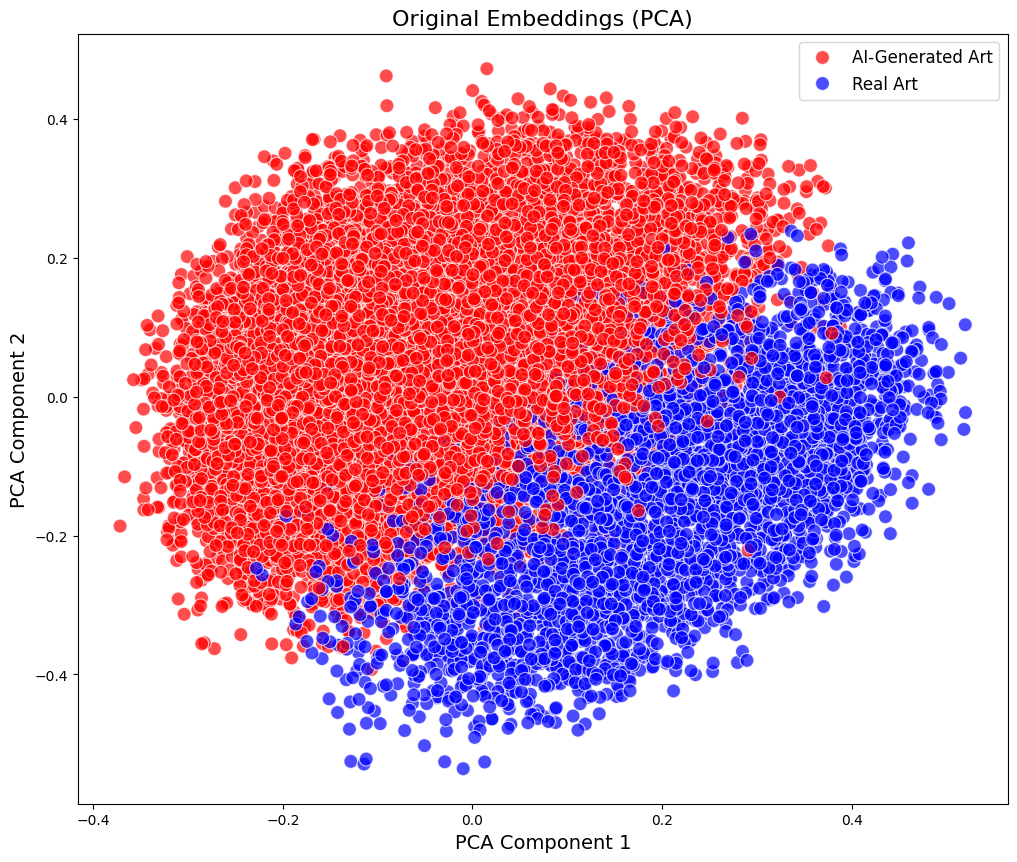

Training accuracy for discriminator: 0.9982

Epoch 1/5
Average Generator Loss: 1.0036, Fool Rate: 0.0015
Evaluation - Average SVM 'real' probability: 0.0039
Evaluation - Fool rate (classified as real): 0.0016

Epoch 2/5
Average Generator Loss: 0.9999, Fool Rate: 0.0013
Evaluation - Average SVM 'real' probability: 0.0039
Evaluation - Fool rate (classified as real): 0.0016

Epoch 3/5
Average Generator Loss: 0.9994, Fool Rate: 0.0014
Evaluation - Average SVM 'real' probability: 0.0038
Evaluation - Fool rate (classified as real): 0.0016


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualization saved to /content/drive/MyDrive/IDL Image Generation/embeddings_epoch_3_tsne.png


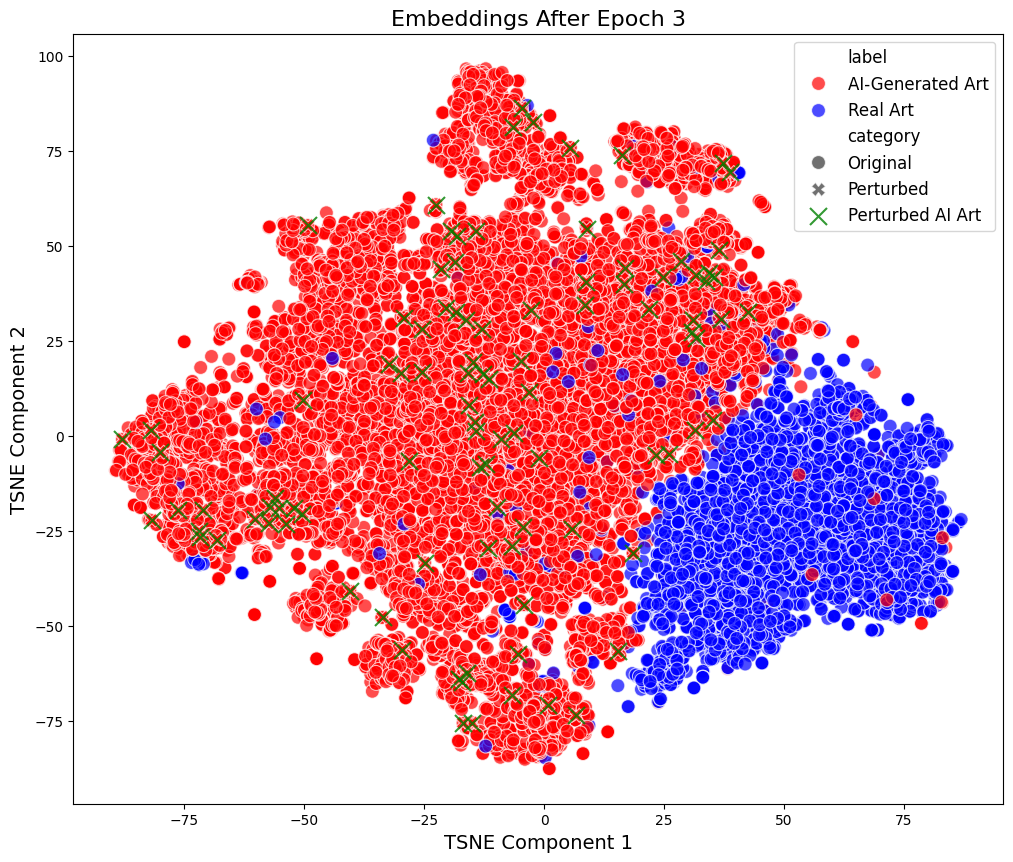


Epoch 4/5
Average Generator Loss: 0.9991, Fool Rate: 0.0014
Evaluation - Average SVM 'real' probability: 0.0038
Evaluation - Fool rate (classified as real): 0.0016

Epoch 5/5
Average Generator Loss: 0.9988, Fool Rate: 0.0014
Evaluation - Average SVM 'real' probability: 0.0037
Evaluation - Fool rate (classified as real): 0.0016


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualization saved to /content/drive/MyDrive/IDL Image Generation/embeddings_epoch_5_tsne.png


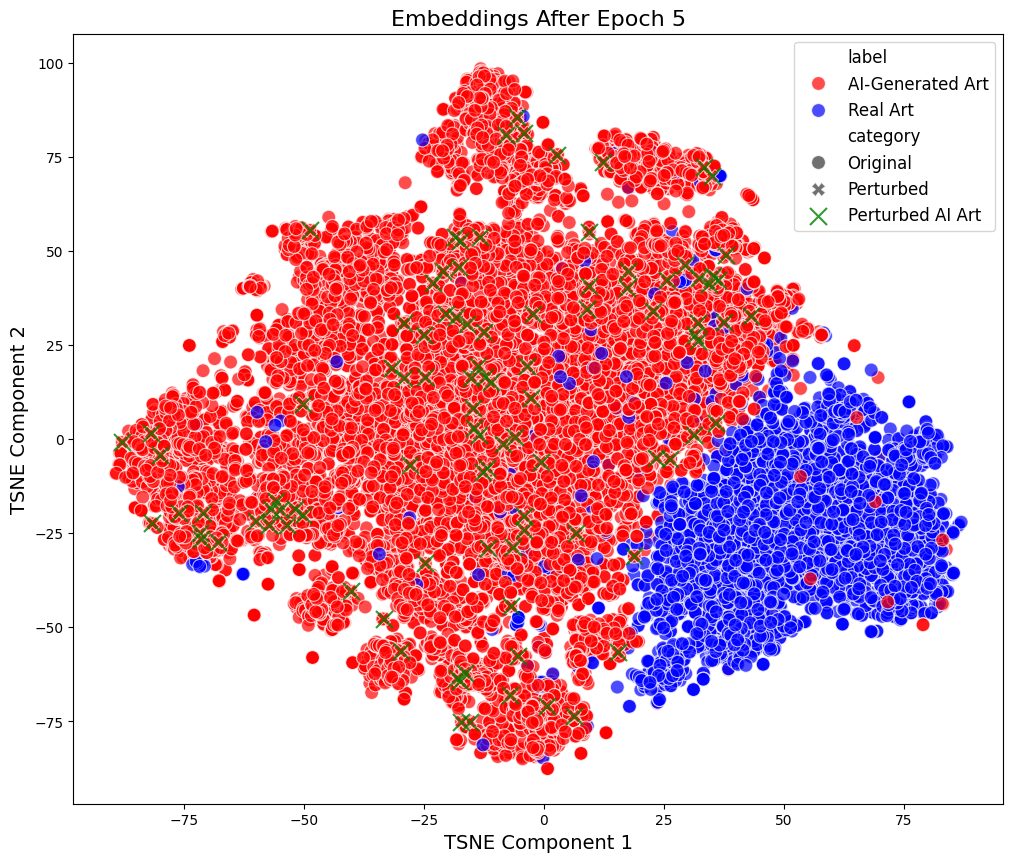


Final Discriminator Evaluation:
Accuracy: 0.9963
Precision: 0.9963
Recall: 0.9963
F1 Score: 0.9963
AUC: 0.9998
mAP: 0.7782


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualization saved to /content/drive/MyDrive/IDL Image Generation/final_embeddings_comparison_tsne.png


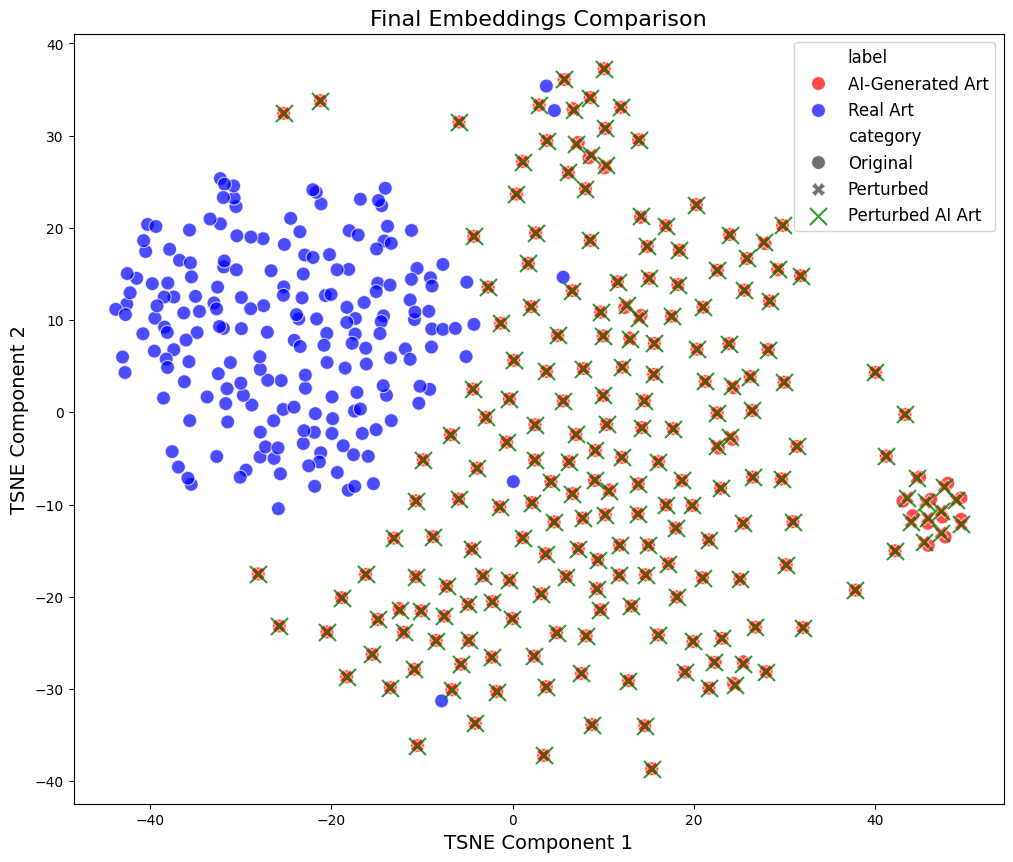

Training complete!


In [ ]:
import os
import csv
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


class CLIPSVMDiscriminator:
    """
    A discriminator that leverages the CLIP model for feature extraction and an SVM classifier
    to label an image as real (human–created art) or fake (AI–generated art, even after adding noise).
    """
    def __init__(self, model_name="openai/clip-vit-base-patch32", device=None):
        # Set device to GPU if available.
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Running on:", "cuda" if torch.cuda.is_available() else "cpu")

        # Load the CLIP model and processor.
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        # Initialize the SVM classifier.
        # Here we use a linear kernel and probability estimates.
        self.svm = SVC(kernel="linear", C=1.0, probability=True)
        self.svm_trained = False

    def run_clip(self, image_path):
      with Image.open(image_path) as img:
        img = img.convert("RGB")
        if img.size != (512, 512):
          print(f"Resizing {image_path} to 512x512")
          img = img.resize((512, 512))
          img.save(image_path)
      # inputs = processor(images=img, return_tensors="pt", padding=True, truncation=True)
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      inputs = self.processor(images=img, return_tensors="pt")
      inputs = inputs.to(device)
      with torch.no_grad():
        # image_features = model.get_image_features(**inputs)
        outputs = self.model.vision_model(inputs.pixel_values)
        image_features = outputs.last_hidden_state[:, 0, :]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features.squeeze().cpu().numpy()

    def train_svm(self, X_train, y_train):
        """
        Train the internal SVM classifier using the provided features and labels.

        Parameters:
            X_train (np.ndarray): Training feature vectors.
            y_train (np.ndarray): Corresponding labels.

        Returns:
            The trained SVM classifier.
        """
        self.svm.fit(X_train, y_train)
        self.svm_trained = True
        train_accuracy = self.svm.score(X_train, y_train)
        print(f"Training accuracy for discriminator: {train_accuracy:.4f}")
        return self.svm

    def predict_from_embeddings(self, embeddings):
        """
        Given a numpy array of embeddings (shape: [B, 768]), use the trained SVM to predict labels
        and output probabilities that the embedding is from a "real" image.
        """
        preds = self.svm.predict(embeddings)
        probs = self.svm.predict_proba(embeddings)[:, 1]
        return preds, probs

    def evaluate(self, X_test, y_test):
        y_pred = self.svm.predict(X_test)
        y_pred_proba = self.svm.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc = roc_auc_score(y_test, y_pred_proba)

        # Calculate mean average precision (mAP)
        ap_per_class = []
        for class_label in np.unique(y_test):
            y_test_binary = (y_test == class_label).astype(int)
            ap = average_precision_score(y_test_binary, y_pred_proba)
            ap_per_class.append(ap)
        map_score = np.mean(ap_per_class)

        # Print results
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print(f"mAP: {map_score:.4f}")

        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
            "map": map_score
        }



def string_to_np(feature_str):
    embedding_list = np.fromstring(feature_str[1:-1], sep=' ')
    assert len(embedding_list) == 768
    return np.array(embedding_list.astype(np.float32))



def train_generator(generator, fixed_discriminator, dataloader, optimizer, device, lambda_reg=0.1):
    """
    Parameters:
      generator (nn.Module): The generator network.
      fixed_discriminator (CLIPSVMDiscriminator): The fixed SVM-based discriminator.
      dataloader (DataLoader): Provides batches of input images (e.g., AI-generated art).
      optimizer (torch.optim.Optimizer): Optimizer for the generator.
      device (torch.device): The device to run computations on.
      lambda_reg (float): Regularization weight for the noise magnitude.

    Returns:
      float: The average generator loss.
    """
    generator.train()
    total_loss = 0.0
    for batch in dataloader:
        # Here, assume the dataloader gives you input image tensors of shape (B, 3, H, W)
        # corresponding to your AI-generated images.
        # For example, batch could be a dictionary with key "images".
        x = batch["features"].to(device)

        # Forward pass through the generator.
        x_noisy, noise = generator(x)

        # === Surrogate Loss Computation ===
        # (1) A reconstruction loss that encourages the perturbed image to stay close to the input.
        recon_loss = F.mse_loss(x_noisy, x)
        # (2) A noise regularization term that penalizes large perturbations.
        noise_loss = torch.mean(torch.norm(noise.view(noise.size(0), -1), dim=1))
        loss = recon_loss + lambda_reg * noise_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Average Generator Loss: {avg_loss:.4f}")
    return avg_loss

def train_generator_with_selective_noise(generator, fixed_discriminator, dataloader, optimizer, device, lambda_reg=0.1):
    """
    Train the generator to add noise only to AI-generated embeddings.

    Parameters:
      generator (nn.Module): The generator network.
      fixed_discriminator (CLIPSVMDiscriminator): The fixed SVM-based discriminator.
      dataloader (DataLoader): Provides batches of input embeddings.
      optimizer (torch.optim.Optimizer): Optimizer for the generator.
      device (torch.device): The device to run computations on.
      lambda_reg (float): Regularization weight for the noise magnitude.

    Returns:
      float: The average generator loss.
    """
    generator.train()
    total_loss = 0.0
    total_fool_rate = 0.0
    batch_count = 0

    for batch in dataloader:
        # Get embeddings and labels from dataloader
        x = batch["features"]
        labels = batch["label"]

        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32)
        if not torch.is_tensor(labels):
            labels = torch.tensor(labels, dtype=torch.long)

        x = x.to(device)
        labels = labels.to(device)

        # Only select AI-generated samples (label = 0)
        ai_indices = (labels == 0).nonzero(as_tuple=True)[0]

        # Skip this batch if there are no AI-generated samples
        if len(ai_indices) == 0:
            continue

        x_ai = x[ai_indices]

        # Forward pass through the generator to get perturbed embeddings for AI samples
        x_noisy, noise = generator(x_ai)

        # Convert to numpy for SVM prediction
        x_noisy_np = x_noisy.detach().cpu().numpy()

        # Get SVM predictions on the perturbed embeddings
        _, probs = fixed_discriminator.predict_from_embeddings(x_noisy_np)
        probs_tensor = torch.tensor(probs, device=device)

        adversarial_loss = torch.mean(1 - probs_tensor)

        # Regularization to keep the noise small
        noise_magnitude = torch.mean(torch.norm(noise, dim=1))

        # Total loss with regularization
        loss = adversarial_loss + lambda_reg * noise_magnitude

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Track how often the generator fools the discriminator (prob > 0.5)
        fool_rate = (probs > 0.5).mean()
        total_fool_rate += fool_rate
        batch_count += 1

    avg_loss = total_loss / batch_count if batch_count > 0 else 0
    avg_fool_rate = total_fool_rate / batch_count if batch_count > 0 else 0
    print(f"Average Generator Loss: {avg_loss:.4f}, Fool Rate: {avg_fool_rate:.4f}")
    return avg_loss, avg_fool_rate



def visualize_embeddings(embeddings, labels, method='tsne', title='Embedding Visualization',
                         save_path=None, perturbed_embeddings=None):
    """
    Visualize high-dimensional embeddings in 2D using PCA or t-SNE.

    Parameters:
        embeddings: numpy array of embeddings with shape (n_samples, n_features)
        labels: numpy array of labels (0 for AI-generated, 1 for real)
        method: 'pca' or 'tsne'
        title: title for the plot
        save_path: path to save the visualization
        perturbed_embeddings: optional, perturbed AI embeddings to visualize
    """
    plt.figure(figsize=(12, 10))

    # Create a DataFrame for easier plotting
    if perturbed_embeddings is None:
        # Standard visualization for original embeddings
        if method == 'pca':
            reducer = PCA(n_components=2)
        else:  # t-SNE
            reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

        reduced_embeddings = reducer.fit_transform(embeddings)

        df = pd.DataFrame({
            'x': reduced_embeddings[:, 0],
            'y': reduced_embeddings[:, 1],
            'label': ['Real Art' if l == 1 else 'AI-Generated Art' for l in labels]
        })

        # Create the scatter plot
        sns.scatterplot(data=df, x='x', y='y', hue='label', palette={'Real Art': 'blue', 'AI-Generated Art': 'red'},
                        alpha=0.7, s=100)

    else:
        # Visualization with perturbed embeddings
        # Combine original and perturbed embeddings
        combined_embeddings = np.vstack([embeddings, perturbed_embeddings])

        # Create labels for the combined dataset
        combined_labels = np.concatenate([
            labels,  # Original labels
            np.zeros(perturbed_embeddings.shape[0])  # Perturbed embeddings (all AI-generated)
        ])

        # Create a category column
        categories = np.concatenate([
            np.array(['Original'] * len(labels)),
            np.array(['Perturbed'] * len(perturbed_embeddings))
        ])

        # Reduce dimensions
        if method == 'pca':
            reducer = PCA(n_components=2)
        else:  # t-SNE
            reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

        reduced_embeddings = reducer.fit_transform(combined_embeddings)

        # Create DataFrame for plotting
        df = pd.DataFrame({
            'x': reduced_embeddings[:, 0],
            'y': reduced_embeddings[:, 1],
            'label': ['Real Art' if l == 1 else 'AI-Generated Art' for l in combined_labels],
            'category': categories
        })

        # Create a custom color palette
        palette = {
            ('Real Art', 'Original'): 'blue',
            ('AI-Generated Art', 'Original'): 'red',
            ('AI-Generated Art', 'Perturbed'): 'green'
        }

        # Create the scatter plot
        sns.scatterplot(
            data=df, x='x', y='y',
            hue='label', style='category',
            palette={'Real Art': 'blue', 'AI-Generated Art': 'red'},
            alpha=0.7, s=100
        )

        # Add a separate scatter for perturbed embeddings
        perturbed_df = df[df['category'] == 'Perturbed']
        plt.scatter(perturbed_df['x'], perturbed_df['y'], color='green', marker='x', s=150, alpha=0.8, label='Perturbed AI Art')

    plt.title(title, fontsize=16)
    plt.xlabel(f"{method.upper()} Component 1", fontsize=14)
    plt.ylabel(f"{method.upper()} Component 2", fontsize=14)
    plt.legend(fontsize=12)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")

    plt.show()


def evaluate_generator_with_discriminator(generator, fixed_discriminator, ai_dataloader, device):
    """
    Evaluate the generator's outputs by passing the generated (perturbed) embeddings to
    the fixed SVM discriminator. This function computes the average SVM probability
    that the perturbed embeddings are classified as "real."

    This version only evaluates on AI-generated samples.
    """
    generator.eval()
    all_probs = []
    all_preds = []
    original_embeddings = []
    perturbed_embeddings = []

    with torch.no_grad():
        for batch in ai_dataloader:
            x = batch["features"]
            if not torch.is_tensor(x):
                x = torch.tensor(x, dtype=torch.float32)
            x = x.to(device)


            original_embeddings.append(x.cpu().numpy())

            # Generate perturbed embeddings
            x_noisy, _ = generator(x)

            # Keep perturbed embeddings for visualization
            perturbed_embeddings.append(x_noisy.cpu().numpy())


            x_noisy_np = x_noisy.cpu().numpy()

            preds, probs = fixed_discriminator.predict_from_embeddings(x_noisy_np)

            all_preds.extend(preds)
            all_probs.extend(probs)

    if len(all_probs) > 0:
        avg_prob = np.mean(all_probs)
        fool_rate = np.mean(np.array(all_preds) == 1)  # Rate at which embeddings are classified as "real"

        print(f"Evaluation - Average SVM 'real' probability: {avg_prob:.4f}")
        print(f"Evaluation - Fool rate (classified as real): {fool_rate:.4f}")

        # Concatenate all embedding arrays
        original_embeddings = np.vstack(original_embeddings) if original_embeddings else np.array([])
        perturbed_embeddings = np.vstack(perturbed_embeddings) if perturbed_embeddings else np.array([])

        return avg_prob, fool_rate, original_embeddings, perturbed_embeddings
    else:
        print("No AI-generated samples to evaluate")
        return 0, 0, None, None



if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    discriminator = CLIPSVMDiscriminator(device=device)
    generator = NoiseGenerator().to(device)
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


    CSV_PATH = os.path.join("/content/drive/MyDrive/IDL Image Generation", "images_hidden_state_embedding.csv")
    dataset = ArtEmbeddingDataset(CSV_PATH)
    # print(dataset.data.head)
    df = pd.read_csv(CSV_PATH)
    X = np.stack(df["Features"].apply(string_to_np).to_numpy())
    y = df["Label"].to_numpy()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # First, visualize the original embeddings
    visualize_embeddings(X, y, method='tsne', title='Original Embeddings (t-SNE)',
                         save_path=os.path.join(ROOT, 'original_embeddings_tsne.png'))
    visualize_embeddings(X, y, method='pca', title='Original Embeddings (PCA)',
                         save_path=os.path.join(ROOT, 'original_embeddings_pca.png'))

    # Train the discriminator (SVM)
    discriminator.train_svm(X_train, y_train)

    # Create datasets
    # 1. Full dataset (with both real and AI art)
    full_dataset = ArtEmbeddingDataset(CSV_PATH)
    full_dataloader = DataLoader(full_dataset, batch_size=32, shuffle=True)

    # 2. AI-only dataset for targeted training
    ai_dataset = ArtEmbeddingDataset(CSV_PATH, ai_only=True)
    ai_dataloader = DataLoader(ai_dataset, batch_size=32, shuffle=True)

    # Create a test dataloader with unseen AI-generated data only
    ai_test_indices = np.where(y_test == 0)[0]
    X_test_ai = X_test[ai_test_indices]
    y_test_ai = y_test[ai_test_indices]

    test_ai_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_test_ai, dtype=torch.float32),
        torch.tensor(y_test_ai, dtype=torch.long)
    )
    test_ai_dataloader = DataLoader(
        dataset=test_ai_dataset,
        batch_size=32,
        shuffle=False
    )

    # Convert test_ai_dataloader to match the format expected by evaluate_generator_with_discriminator
    class AITestDataset(Dataset):
        def __init__(self, X, y):
            self.features = X
            self.labels = y

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return {
                "features": self.features[idx],
                "label": self.labels[idx]
            }

    ai_test_dataset = AITestDataset(X_test_ai, y_test_ai)
    ai_test_dataloader = DataLoader(ai_test_dataset, batch_size=32, shuffle=False)



    num_epochs = 5
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        loss, fool_rate = train_generator_with_selective_noise(generator, discriminator, full_dataloader, gen_optimizer, device, lambda_reg=0.1)

        # Evaluate generator performance on test data
        if (epoch + 1) % 1 == 0:  # Evaluate every epoch
            eval_prob, eval_fool_rate, original_embeddings, perturbed_embeddings = evaluate_generator_with_discriminator(
                generator, discriminator, ai_test_dataloader, device)

            # Visualize after some training
            if epoch == 2 or epoch == num_epochs - 1:
                # Get some AI samples for visualization
                ai_indices = np.where(y == 0)[0]
                ai_samples = X[ai_indices[:100]]  # Take first 100 AI samples
                ai_labels = np.zeros(len(ai_samples))

                # Get perturbed versions
                with torch.no_grad():
                    generator.eval()
                    ai_tensor = torch.tensor(ai_samples, dtype=torch.float32).to(device)
                    perturbed_ai, _ = generator(ai_tensor)
                    perturbed_ai = perturbed_ai.cpu().numpy()

                # Visualize
                title = f'Embeddings After Epoch {epoch+1}'
                visualize_embeddings(X, y, method='tsne', title=title,
                                     save_path=os.path.join(ROOT, f'embeddings_epoch_{epoch+1}_tsne.png'),
                                     perturbed_embeddings=perturbed_ai)

    # Final evaluation of the discriminator
    print("\nFinal Discriminator Evaluation:")
    metrics = discriminator.evaluate(X_test, y_test)


    ai_indices = np.where(y == 0)[0][:200]  # Take first 200 AI samples
    real_indices = np.where(y == 1)[0][:200]  # Take first 200 real samples

    combined_indices = np.concatenate([ai_indices, real_indices])
    combined_samples = X[combined_indices]
    combined_labels = y[combined_indices]

    # Get perturbed versions of AI samples
    ai_samples = X[ai_indices]
    with torch.no_grad():
        generator.eval()
        ai_tensor = torch.tensor(ai_samples, dtype=torch.float32).to(device)
        perturbed_ai, _ = generator(ai_tensor)
        perturbed_ai = perturbed_ai.cpu().numpy()

    visualize_embeddings(combined_samples, combined_labels, method='tsne',
                         title='Final Embeddings Comparison',
                         save_path=os.path.join(ROOT, 'final_embeddings_comparison_tsne.png'),
                         perturbed_embeddings=perturbed_ai)

    # Save the trained models
    torch.save(generator.state_dict(), os.path.join(ROOT, "noise_generator.pth"))
    joblib.dump(discriminator.svm, os.path.join(ROOT, "clip_svm_discriminator.joblib"))

    print("Training complete!")